In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler
from sklearn.feature_selection import f_classif
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from itertools import cycle

In [2]:
# 读取训练集和测试集数据
train_data = pd.read_csv('data/features/train_data.csv')
test_data = pd.read_csv('data/features/test_data.csv')

# 查看各列属性的数据量和缺失情况
print(train_data.info())
print(test_data.info())

# 查看各列属性的基本统计信息，
print(train_data.describe())
print(test_data.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51006 entries, 0 to 51005
Data columns (total 100 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   pre_r                      51006 non-null  float64
 1   post_r                     51006 non-null  float64
 2   local_r                    51006 non-null  float64
 3   global_r                   51006 non-null  float64
 4   norm_pre_r                 51006 non-null  float64
 5   norm_post_r                51006 non-null  float64
 6   norm_local_r               51006 non-null  float64
 7   norm_global_r              51006 non-null  float64
 8   ps_exp                     51006 non-null  float64
 9   ps_std                     51006 non-null  float64
 10  ps_skew                    51006 non-null  float64
 11  ps_kurt                    51006 non-null  float64
 12  freq_exp                   51006 non-null  float64
 13  freq_std                   51006 non-null  fl

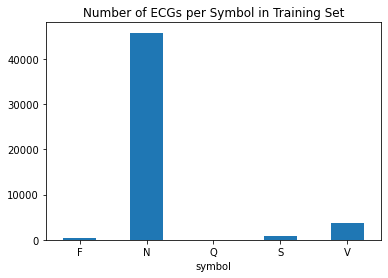

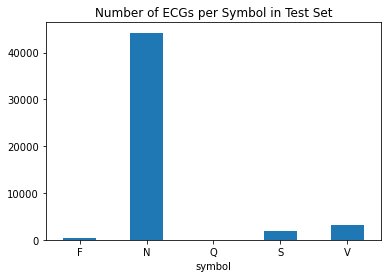

symbol
F      414
N    45852
Q        8
S      944
V     3788
dtype: int64
symbol
F      388
N    44245
Q        7
S     1837
V     3220
dtype: int64


In [3]:
# 统计每种心拍的数量
train_data_plot = train_data[['symbol']].groupby('symbol').size()
train_data_plot.plot(kind='bar', title='Number of ECGs per Symbol in Training Set')
plt.xticks(rotation=0)
plt.savefig('figures/train_data_plot.jpg', dpi=300)
plt.show()

test_data_plot = test_data[['symbol']].groupby('symbol').size()
test_data_plot.plot(kind='bar', title='Number of ECGs per Symbol in Test Set')
plt.xticks(rotation=0)
plt.savefig('figures/test_data_plot.jpg', dpi=300)
plt.show()

print(train_data_plot)
print(test_data_plot)

In [4]:
# 删除Q类别心拍
train_data = train_data[train_data['symbol']!= 'Q'].reset_index(drop=True)
test_data = test_data[test_data['symbol']!= 'Q'].reset_index(drop=True)

# 训练集和测试集的标签
train_y = train_data['symbol']
test_y = test_data['symbol']

# 训练集和测试集的特征
train_X = train_data.drop(['symbol'], axis=1)
test_X = test_data.drop(['symbol'], axis=1)

print(train_X.shape)
print(test_X.shape)

(50998, 99)
(49690, 99)


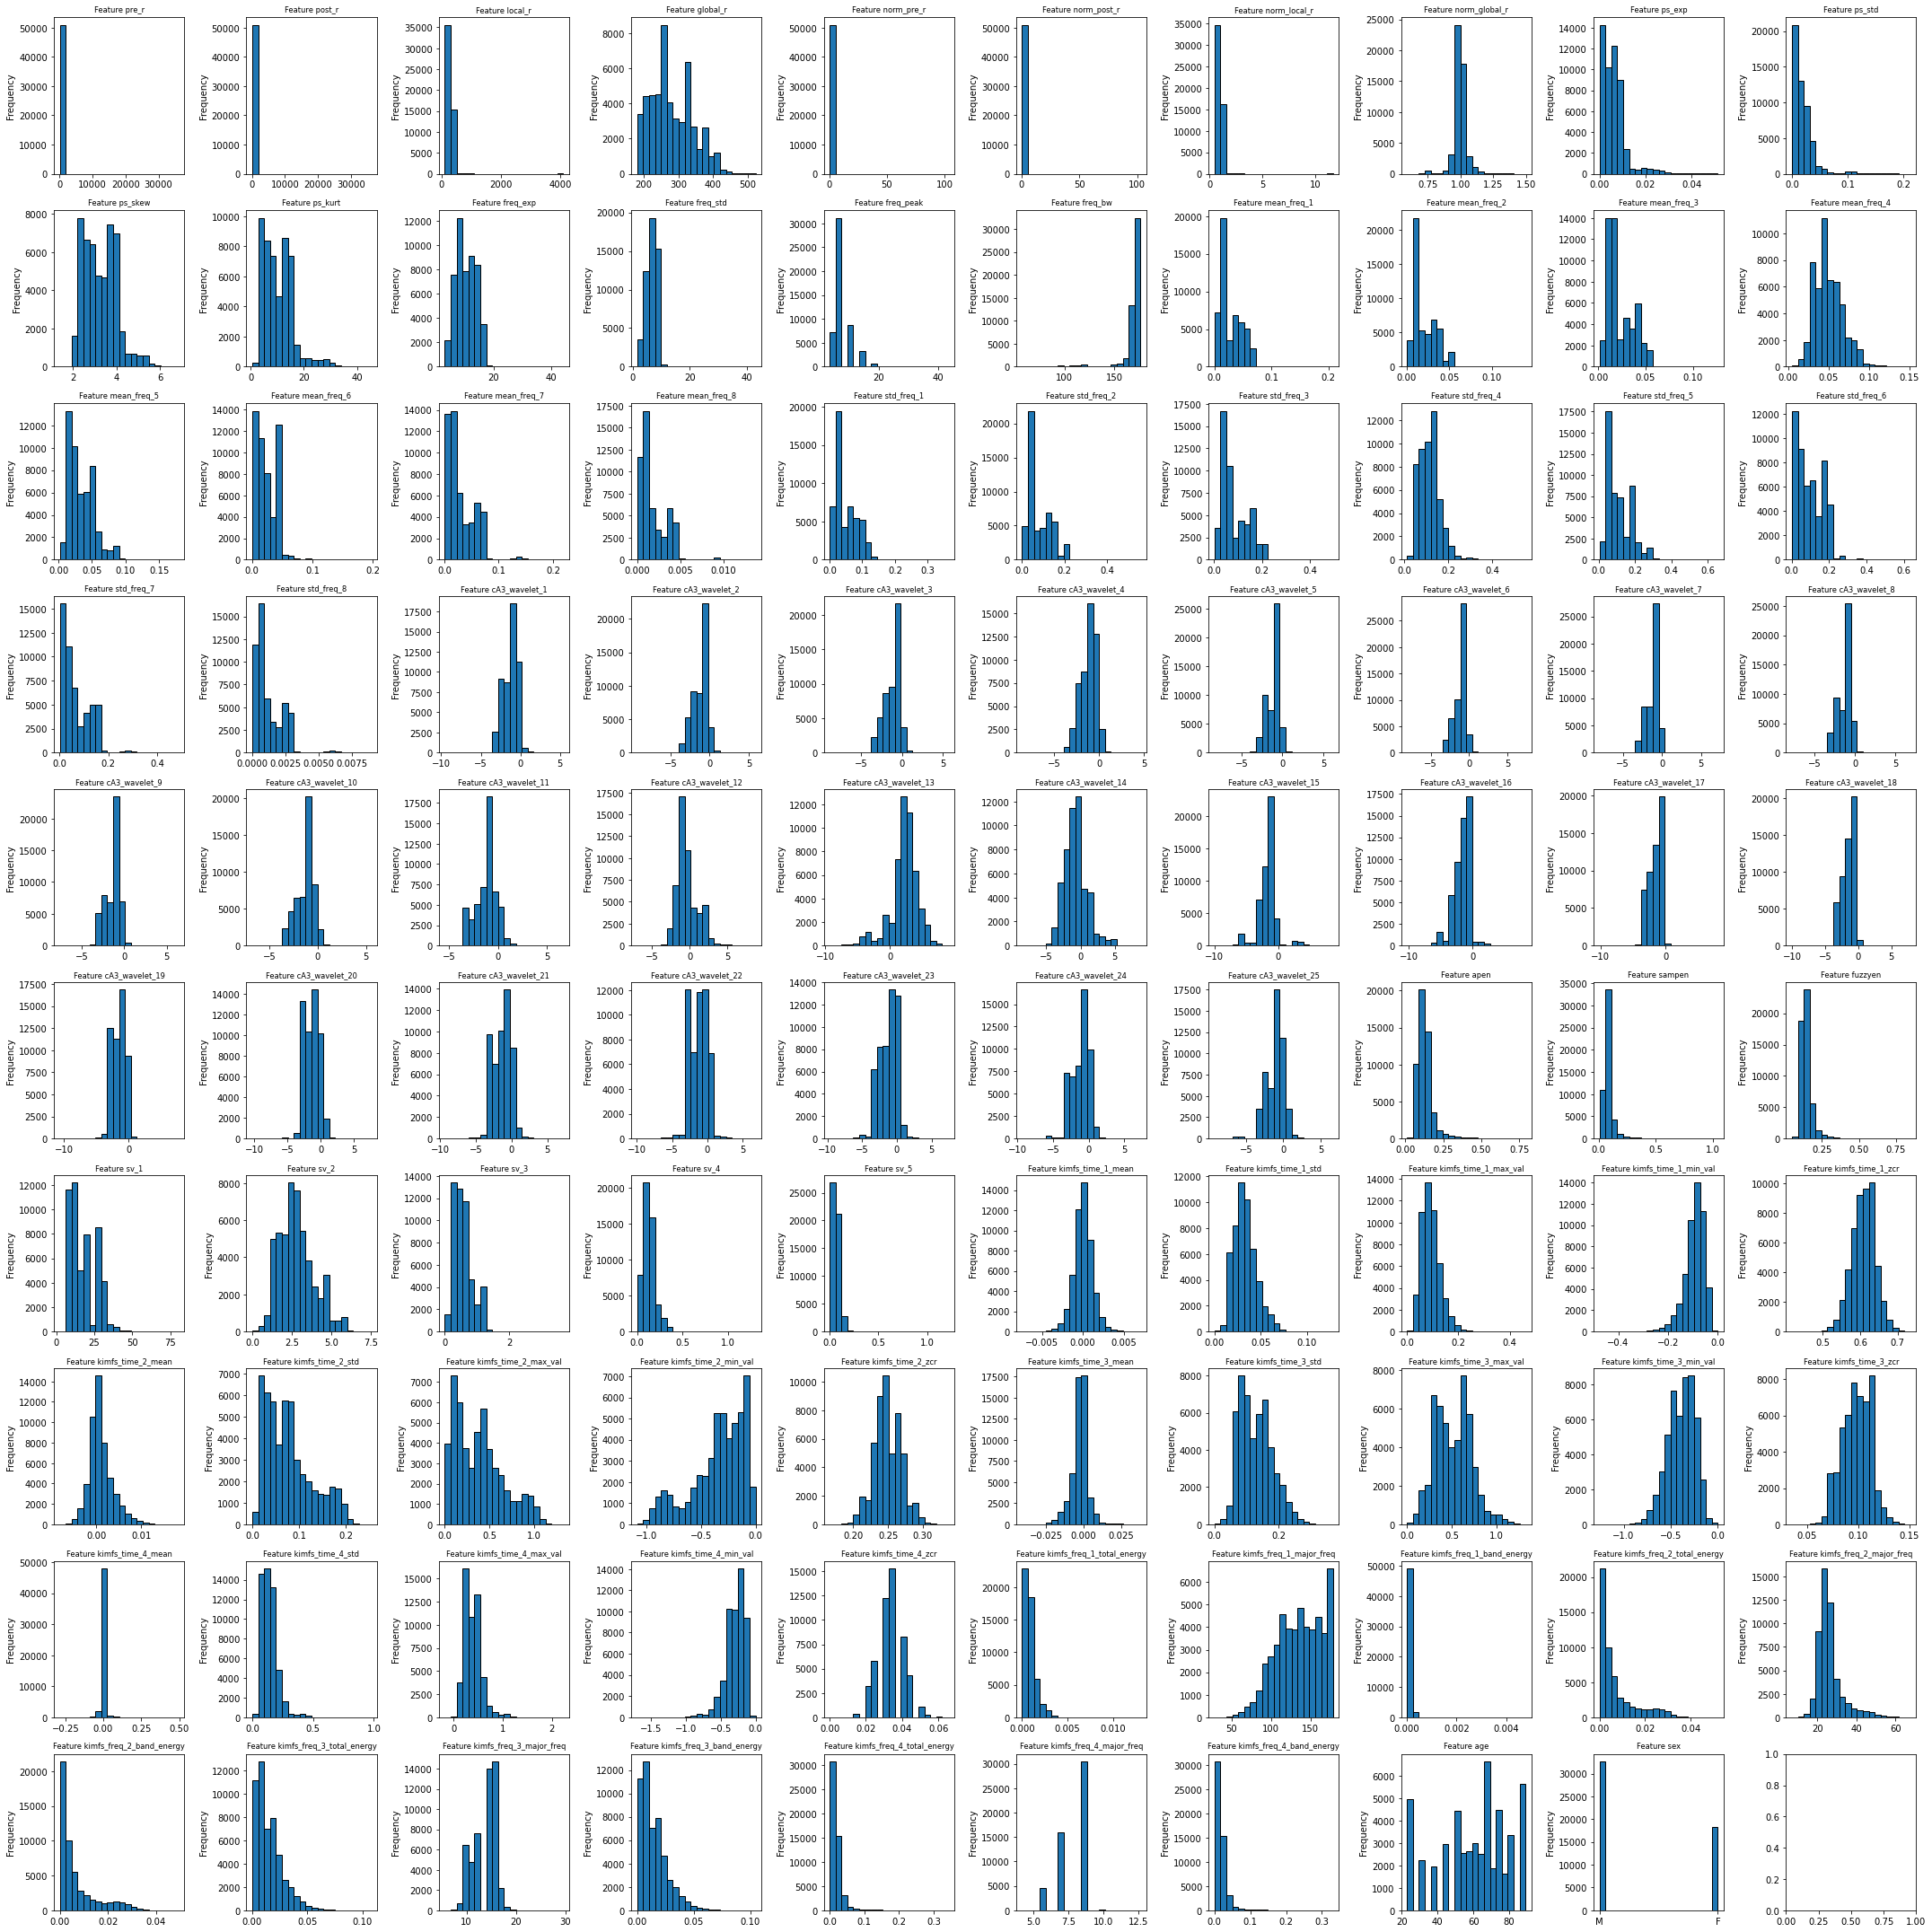

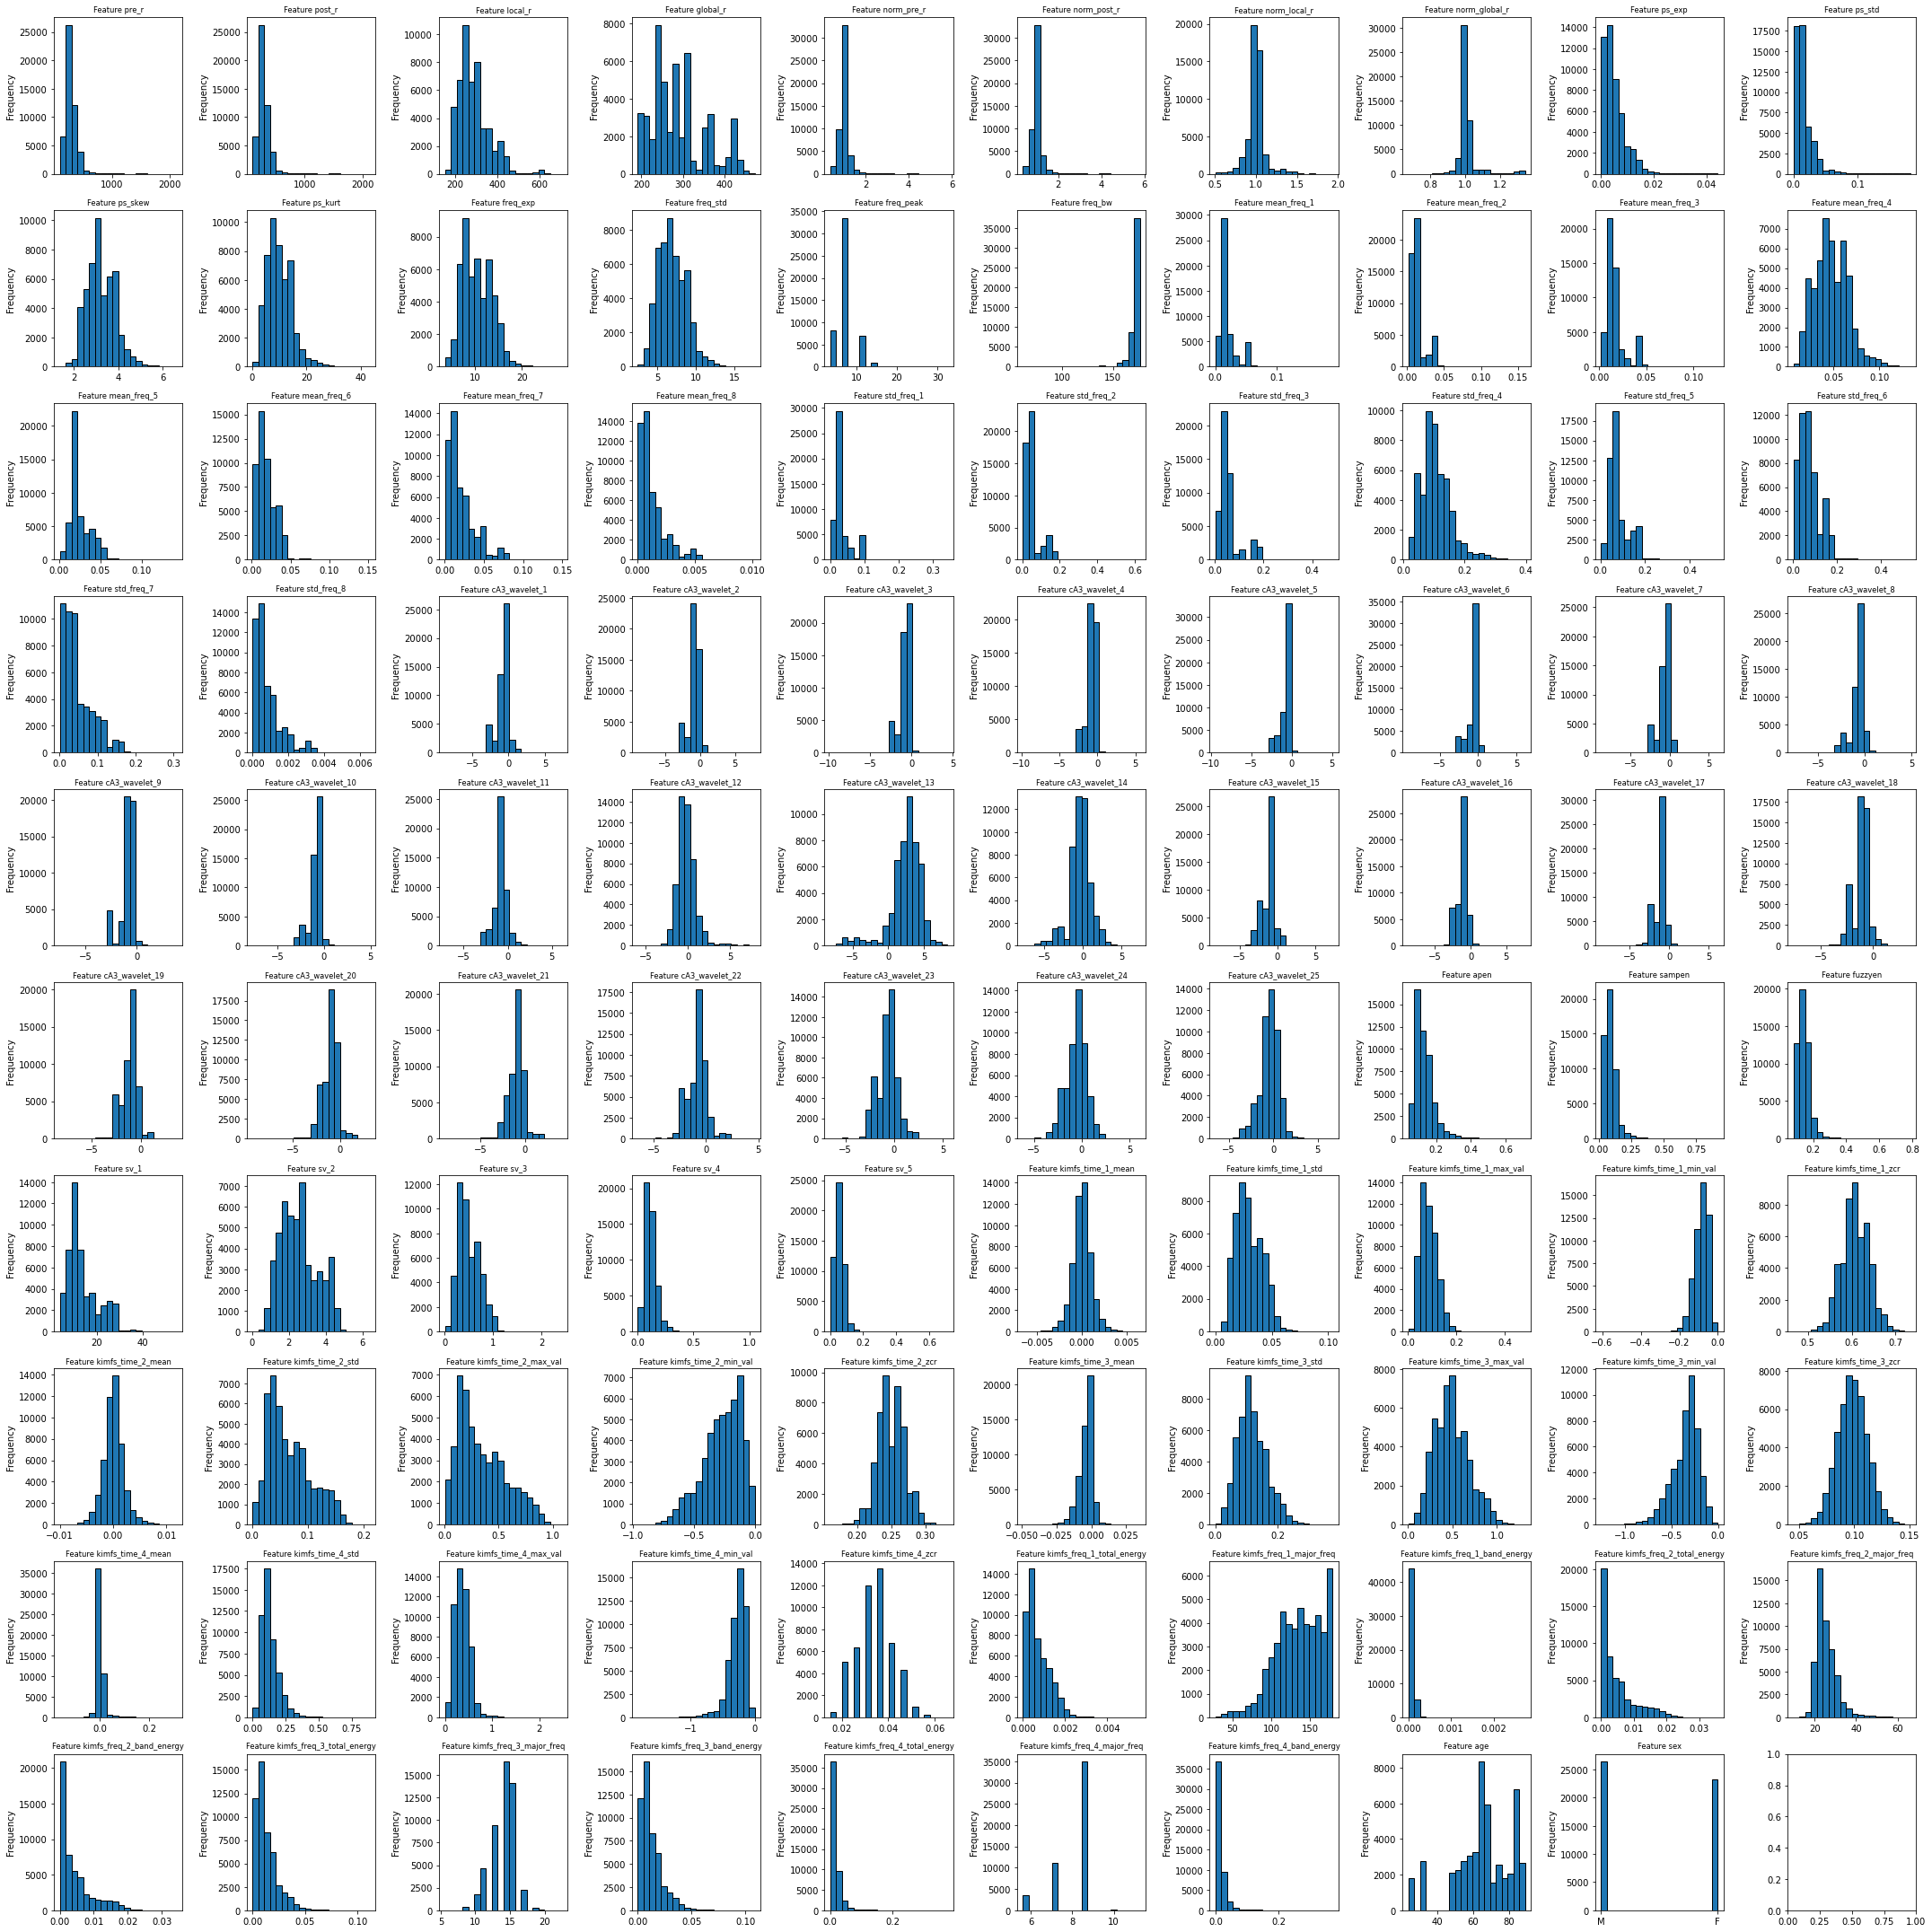

In [5]:
# 查看特征分布
feature_cols = train_X.columns.tolist()

# 计算子图网格所需的行数和列数
num_rows = 10
num_cols = 10

# 创建子图网格
fig, axs = plt.subplots(num_rows, num_cols, figsize=(30, 30), tight_layout=True)

# 遍历子图并绘制直方图
for i, (col, ax) in enumerate(zip(feature_cols, axs.flatten())):
    ax.hist(train_X[col].dropna(), bins=20, edgecolor='black')  # 调整bins数量以适应您的需求
    ax.set_title(f'Feature {col}', fontsize='small')  # 调整字体大小以适应您的需求
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')

plt.savefig('figures/train_feature_distributions.jpg', dpi=300)
plt.show()

# 创建子图网格
fig, axs = plt.subplots(num_rows, num_cols, figsize=(30, 30), tight_layout=True)

# 遍历子图并绘制直方图
for i, (col, ax) in enumerate(zip(feature_cols, axs.flatten())):
    ax.hist(test_X[col].dropna(), bins=20, edgecolor='black')  # 调整bins数量以适应您的需求
    ax.set_title(f'Feature {col}', fontsize='small')  # 调整字体大小以适应您的需求
    ax.set_xlabel('')
    ax.set_ylabel('Frequency')

plt.savefig('figures/test_feature_distributions.jpg', dpi=300)
plt.show()

In [6]:
# 计算性别特征的列索引
sex_index = train_X.shape[1] - 1

# 创建一个独热编码器，只对性别特征进行编码
encoder = OneHotEncoder(drop='first', sparse=False)

# 创建一个RobustScaler，用于对数据进行标准化
robust_scaler = RobustScaler()

In [7]:
# 数据预处理
preprocessor = ColumnTransformer(transformers=[
    ('num', robust_scaler, slice(0, sex_index)),
    ('cat', encoder, [sex_index]),
],
                                 remainder='passthrough')

# 转换训练和测试数据
train_X_preprocessed = preprocessor.fit_transform(train_X)
test_X_preprocessed = preprocessor.transform(test_X)

# 将预处理后的数据转换为 DataFrame
train_X_preprocessed = pd.DataFrame(train_X_preprocessed, columns=train_X.columns)
test_X_preprocessed = pd.DataFrame(test_X_preprocessed, columns=test_X.columns)

In [8]:
train_X_preprocessed.head()

,pre_r,post_r,local_r,global_r,norm_pre_r,norm_post_r,norm_local_r,norm_global_r,ps_exp,ps_std,...,kimfs_freq_2_major_freq,kimfs_freq_2_band_energy,kimfs_freq_3_total_energy,kimfs_freq_3_major_freq,kimfs_freq_3_band_energy,kimfs_freq_4_total_energy,kimfs_freq_4_major_freq,kimfs_freq_4_band_energy,age,sex
0,0.206522,0.347826,0.294941,0.327367,-0.009103,0.401487,0.188141,1.525506,0.560582,0.769628,...,0.25,0.411616,1.079869,-1.5,1.083183,1.379401,-1.0,1.393113,0.227273,1.0
1,-0.847826,-0.869565,-0.865390,-0.789827,-0.244619,-0.337873,-0.356726,0.182696,-0.622476,-0.537228,...,-0.50,0.463126,-0.479967,0.5,-0.478651,-0.199792,-2.0,-0.197982,0.772727,1.0
2,0.076087,0.076087,0.148614,0.086207,0.118889,0.118889,0.351787,0.823114,2.340156,1.900660,...,0.00,2.970827,2.427056,0.0,2.409309,2.477631,0.0,2.475329,0.181818,1.0
3,0.217391,-0.434783,-0.315519,-0.515523,2.703189,0.245770,0.974563,0.010531,-0.514124,-0.444966,...,0.25,0.154113,-0.367448,0.5,-0.367369,-0.224254,0.0,-0.224153,-1.863636,0.0
4,1.228261,0.630435,0.961418,0.794672,1.248706,-0.240098,0.584896,0.948394,0.162988,0.001537,...,0.00,3.000872,0.189991,0.5,0.190390,-0.196393,0.0,-0.195608,-1.136364,0.0


In [9]:
# 计算降维后特征的F统计量值
f_statistic, p_values = f_classif(train_X_preprocessed, train_y)
sorted_f_statistic = np.sort(f_statistic)[::-1]
sorted_f_statistic

array([8.94976632e+03, 6.42775031e+03, 4.09312321e+03, 3.74698436e+03,
       3.71640378e+03, 3.41251253e+03, 3.18332135e+03, 3.08640950e+03,
       2.88205883e+03, 2.86031540e+03, 2.79615599e+03, 1.97561962e+03,
       1.68383083e+03, 1.51007745e+03, 1.47479840e+03, 1.37268972e+03,
       1.33687223e+03, 1.31129454e+03, 1.18515891e+03, 1.15413906e+03,
       1.15116711e+03, 1.13432262e+03, 1.09385681e+03, 8.99910782e+02,
       8.56926897e+02, 8.44344382e+02, 7.54838030e+02, 7.40109138e+02,
       7.10664192e+02, 7.00966697e+02, 6.39338792e+02, 6.04231446e+02,
       5.44586066e+02, 5.37340829e+02, 5.05796765e+02, 5.00271261e+02,
       4.89006188e+02, 4.75898302e+02, 4.65716802e+02, 3.85568733e+02,
       3.74907644e+02, 3.70107060e+02, 3.52917351e+02, 3.49437846e+02,
       3.45904897e+02, 3.40987180e+02, 3.34328327e+02, 3.33523715e+02,
       3.14763149e+02, 3.13607493e+02, 3.06755238e+02, 2.64629501e+02,
       2.62737745e+02, 2.36718866e+02, 2.30468911e+02, 2.25692821e+02,
      

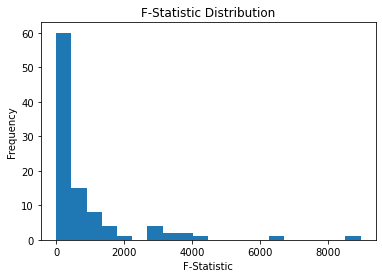

In [10]:
# 查看F统计量的数据分布
plt.hist(f_statistic, bins=20)
plt.xlabel('F-Statistic')
plt.ylabel('Frequency')
plt.title('F-Statistic Distribution')
plt.savefig('figures/F-Statistic Distribution.jpg', dpi=300)
plt.show()

In [11]:
# 计算F统计量的不同分位数
f_percentile = np.percentile(f_statistic, range(0, 101, 2))
f_percentile

array([8.60448087e-01, 5.28363995e+00, 3.01607263e+01, 4.79438762e+01,
       6.37948891e+01, 7.91887541e+01, 8.78681138e+01, 9.64685780e+01,
       1.11931435e+02, 1.17051715e+02, 1.23015355e+02, 1.27043452e+02,
       1.35794697e+02, 1.41021967e+02, 1.49044005e+02, 1.62574824e+02,
       1.77694842e+02, 1.99818675e+02, 2.09296558e+02, 2.14952339e+02,
       2.17413548e+02, 2.21520265e+02, 2.26265952e+02, 2.38800376e+02,
       2.66314531e+02, 3.13607493e+02, 3.32773293e+02, 3.40454472e+02,
       3.49013892e+02, 3.67356707e+02, 3.83436515e+02, 4.73454742e+02,
       4.97117040e+02, 5.27246729e+02, 5.82759109e+02, 6.76315535e+02,
       7.27153361e+02, 8.01381333e+02, 8.77559162e+02, 1.11166177e+03,
       1.15235589e+03, 1.23056774e+03, 1.34833383e+03, 1.48467653e+03,
       1.75386014e+03, 2.80898787e+03, 2.91475494e+03, 3.21082429e+03,
       3.71885022e+03, 4.18650829e+03, 8.94976632e+03])

In [12]:
# 根据F统计量的不同分位数确定阈值
thresholds = np.floor(f_percentile)
thresholds

array([0.000e+00, 5.000e+00, 3.000e+01, 4.700e+01, 6.300e+01, 7.900e+01,
       8.700e+01, 9.600e+01, 1.110e+02, 1.170e+02, 1.230e+02, 1.270e+02,
       1.350e+02, 1.410e+02, 1.490e+02, 1.620e+02, 1.770e+02, 1.990e+02,
       2.090e+02, 2.140e+02, 2.170e+02, 2.210e+02, 2.260e+02, 2.380e+02,
       2.660e+02, 3.130e+02, 3.320e+02, 3.400e+02, 3.490e+02, 3.670e+02,
       3.830e+02, 4.730e+02, 4.970e+02, 5.270e+02, 5.820e+02, 6.760e+02,
       7.270e+02, 8.010e+02, 8.770e+02, 1.111e+03, 1.152e+03, 1.230e+03,
       1.348e+03, 1.484e+03, 1.753e+03, 2.808e+03, 2.914e+03, 3.210e+03,
       3.718e+03, 4.186e+03, 8.949e+03])

In [13]:
# 参数网格搜索
param_grids = {
    'SVC': {'C': [0.1, 1, 10, 100], 'kernel': ['linear', 'rbf']},
    'RandomForestClassifier': {'n_estimators': [10, 50, 100], 'criterion': ['gini', 'entropy']},
    'AdaBoostClassifier': {'n_estimators': [10, 50, 100]},
    'KNeighborsClassifier': {'n_neighbors': [3, 5, 7], 'weights': ['uniform', 'distance']},
    'LogisticRegression': {'C': [0.1, 1, 10, 100], 'penalty': ['l1', 'l2']}
}

# 定义参数搜索函数
def grid_search(model, param_grid, X_train, y_train):
    grid_search = GridSearchCV(model, param_grid, cv=10, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    return grid_search.best_params_

# 定义模型列表
models = [
    SVC(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    KNeighborsClassifier(),
    LogisticRegression()
]

# 遍历模型列表，使用网格搜索寻找最优参数
for model in models:
    print(model.__class__.__name__)
    best_params = grid_search(model, param_grids[model.__class__.__name__], train_X_preprocessed, train_y)
    print(best_params)

SVC
{'C': 10, 'kernel': 'rbf'}
RandomForestClassifier
{'criterion': 'entropy', 'n_estimators': 100}
AdaBoostClassifier
{'n_estimators': 10}
KNeighborsClassifier
{'n_neighbors': 3, 'weights': 'distance'}
LogisticRegression


d:\Users\14715\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Users\14715\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

{'C': 10, 'penalty': 'l2'}


d:\Users\14715\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
# 使用10折交叉验证选择F阈值
kf = KFold(n_splits=10, shuffle=True, random_state=42)
accuracy_scores = []

for threshold in thresholds:
    selected_features = train_X_preprocessed.columns[f_statistic > threshold]  # 选择F统计量大于阈值的特征
    feature_subset = train_X_preprocessed.loc[:, selected_features]

    avg_acc = []
    for train_idx, val_idx in kf.split(feature_subset, train_y):
        X_train, y_train = feature_subset.loc[train_idx], train_y[train_idx]
        X_val, y_val = feature_subset.loc[val_idx], train_y[val_idx]

        # 使用所有模型进行特征选择时的性能评估
        models = [
            SVC(C=10, kernel='rbf'),
            RandomForestClassifier(criterion='entropy', n_estimators=100),
            AdaBoostClassifier(n_estimators=10),
            KNeighborsClassifier(n_neighbors=3, weights='distance'),
            LogisticRegression(C=10, penalty='l2')
        ]
        for model in models:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)
            avg_acc.append(accuracy_score(y_val, y_pred))  # 使用accuracy作为性能指标

    avg_acc = np.mean(avg_acc)
    accuracy_scores.append(avg_acc)

np.array(accuracy_scores).tofile('accuracy.bin')  # 保存accuracy_scores

d:\Users\14715\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Users\14715\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [15]:
accuracy_scores = np.fromfile("accuracy.bin")
accuracy_scores

array([0.98241891, 0.98248951, 0.98263461, 0.98259146, 0.98227772,
       0.9822738 , 0.98211301, 0.9821993 , 0.98212088, 0.98205028,
       0.98214439, 0.9820189 , 0.98203066, 0.98192478, 0.98184634,
       0.98172084, 0.98171692, 0.98165024, 0.98125415, 0.9812071 ,
       0.9807914 , 0.98086984, 0.97948938, 0.9793678 , 0.97912857,
       0.97908151, 0.97903445, 0.97865405, 0.97884623, 0.97854426,
       0.97828936, 0.97831681, 0.97175185, 0.97149695, 0.97106948,
       0.97092828, 0.97095576, 0.97098322, 0.97077929, 0.97054005,
       0.97086555, 0.96746933, 0.96610064, 0.96448881, 0.95934349,
       0.95764539, 0.95511194, 0.95057839, 0.94797438, 0.94053094,
       0.92858542])

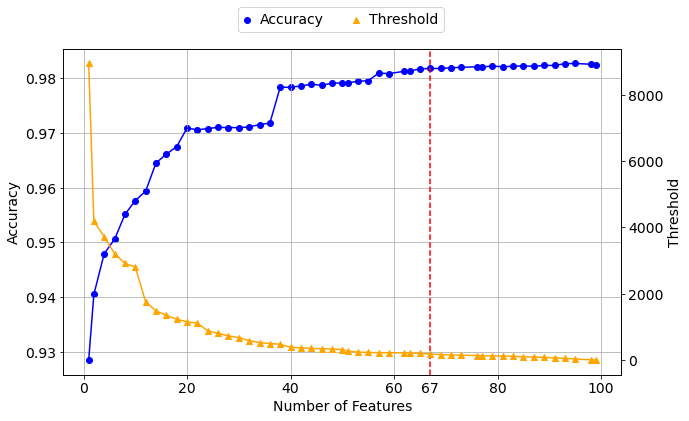

In [16]:
mpl.rcParams['font.size'] = 14  # 设置全局字体大小为14
fig, ax1 = plt.subplots(figsize=(10, 6))

# 设置横坐标
x = np.array([len(train_X_preprocessed.columns[f_statistic > threshold]) for threshold in thresholds[::-1]])

# 绘制Accuracy曲线
line1 = ax1.scatter(x, accuracy_scores[::-1], label='Accuracy', color='blue', marker='o')
ax1.plot(x, accuracy_scores[::-1], color='blue', linestyle='-')

# 绘制阈值曲线
ax2 = ax1.twinx()
line2 = ax2.scatter(x, thresholds[::-1], label='Threshold', color='orange', marker='^')
ax2.plot(x, thresholds[::-1], color='orange', linestyle='-')

# 设置坐标轴名称
ax1.set_ylabel('Accuracy')
ax2.set_ylabel('Threshold')
ax1.set_xlabel('Number of Features')

# 最佳阈值
best_feature_num = int(x[::-1][thresholds == 177])
ax1.axvline(x=best_feature_num, color='red', linestyle='--')
# 在x轴上标记垂直线的位置
ax1.text(best_feature_num, -0.02, f'{best_feature_num}', horizontalalignment='center', verticalalignment='top', transform=ax1.get_xaxis_transform())

# 设置图例
lines = [line1, line2]
labels = [l.get_label() for l in lines]  # 自动获取每个线对象的标签
plt.legend(lines, labels, loc='upper left', bbox_to_anchor=(0.3, 1.15), ncol=2, handlelength=0.5, handletextpad=0.7)  # 添加合并的图例

# 增加网格线以提高清晰度
ax1.grid(True)
plt.savefig('figures/F-Statistic-Threshold.jpg', dpi=300)
plt.show()

In [17]:
# 选择F统计量大于最优阈值的特征，并返回选择后的特征子集
best_threshold = 177
final_selected_features = train_X_preprocessed.columns[f_statistic > best_threshold]
final_feature_subset = train_X_preprocessed.loc[:, final_selected_features]

# 筛选测试集特征
test_feature_subset = test_X_preprocessed.loc[:, final_selected_features]
final_feature_subset.head()

,pre_r,global_r,norm_pre_r,norm_post_r,norm_local_r,ps_exp,ps_std,ps_skew,ps_kurt,freq_exp,...,kimfs_freq_2_total_energy,kimfs_freq_2_major_freq,kimfs_freq_2_band_energy,kimfs_freq_3_total_energy,kimfs_freq_3_band_energy,kimfs_freq_4_total_energy,kimfs_freq_4_major_freq,kimfs_freq_4_band_energy,age,sex
0,0.206522,0.327367,-0.009103,0.401487,0.188141,0.560582,0.769628,0.537014,0.519296,-0.145585,...,0.412742,0.25,0.411616,1.079869,1.083183,1.379401,-1.0,1.393113,0.227273,1.0
1,-0.847826,-0.789827,-0.244619,-0.337873,-0.356726,-0.622476,-0.537228,-0.626723,-0.621380,0.649513,...,0.450208,-0.50,0.463126,-0.479967,-0.478651,-0.199792,-2.0,-0.197982,0.772727,1.0
2,0.076087,0.086207,0.118889,0.118889,0.351787,2.340156,1.900660,-0.174897,-0.168798,0.139436,...,3.002445,0.00,2.970827,2.427056,2.409309,2.477631,0.0,2.475329,0.181818,1.0
3,0.217391,-0.515523,2.703189,0.245770,0.974563,-0.514124,-0.444966,-0.291485,-0.280701,0.346778,...,0.142738,0.25,0.154113,-0.367448,-0.367369,-0.224254,0.0,-0.224153,-1.863636,0.0
4,1.228261,0.794672,1.248706,-0.240098,0.584896,0.162988,0.001537,-0.757777,-0.704192,0.954414,...,2.964444,0.00,3.000872,0.189991,0.190390,-0.196393,0.0,-0.195608,-1.136364,0.0


In [18]:
# 利用10折交叉验证评估五种模型
models = [
    SVC(C=10, kernel='rbf'),
    RandomForestClassifier(criterion='entropy', n_estimators=100),
    AdaBoostClassifier(n_estimators=10),
    KNeighborsClassifier(n_neighbors=3, weights='distance'),
    LogisticRegression(C=10, penalty='l2')
]

# 初始化存储各类别TP、TN、FP、FN的字典
model_scores = {model.__class__.__name__: {'Accuracy': 0, 'Macro_F1_Score': 0, 'Sensitivities': {}, 'Specificities': {}} for model in models}

kf = KFold(n_splits=10, shuffle=True, random_state=21)

# 获取实际类别标签列表
class_labels = np.unique(train_y)

# 定义训练评估函数
def train_and_evaluate(model, X_train, y_train, X_val, y_val):
    model_score = {'Accuracy': 0, 'Macro_F1_Score': 0, 'Sensitivities': {}, 'Specificities': {}}

    # 训练模型并预测
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    # 计算混淆矩阵，指定类别标签顺序
    cm = confusion_matrix(y_val, y_pred, labels=class_labels)
    model_score['Confusion_Matrix'] = cm

    # 计算并存储各类别的TP、TN、FP、FN
    tp = {class_labels[i]: cm[i, i] for i in range(len(class_labels))}
    tn = {class_labels[i]: np.sum(cm[:, :i]) + np.sum(cm[:, i+1:]) for i in range(len(class_labels))}
    fp = {class_labels[i]: np.sum(cm[:i, i]) + np.sum(cm[i+1:, i]) for i in range(len(class_labels))}
    fn = {class_labels[i]: np.sum(cm[i, :i]) + np.sum(cm[i, i+1:]) for i in range(len(class_labels))}
    model_score['TP'] = tp
    model_score['TN'] = tn
    model_score['FP'] = fp
    model_score['FN'] = fn

    # 计算总准确率
    model_score['Accuracy'] = accuracy_score(y_val, y_pred)

    # 计算各类别的灵敏度
    model_score['Sensitivities'] = {label: tp[label] / (tp[label] + fn[label]) for label in class_labels}

    # 计算各类别的特异度
    model_score['Specificities'] = {label: tn[label] / (tn[label] + fp[label]) for label in class_labels}

    # 计算macro F1-score
    model_score['Macro_F1_Score'] = f1_score(y_val, y_pred, average='macro')

    return model_score

for model in models:
    model_name = model.__class__.__name__

    # 初始化各类别的灵敏度和特异度
    for label in class_labels:
        model_scores[model_name]['Sensitivities'][label] = 0
        model_scores[model_name]['Specificities'][label] = 0

    for train_idx, val_idx in kf.split(final_feature_subset, train_y):
        model_name = model.__class__.__name__
        
        X_train, y_train = final_feature_subset.iloc[train_idx], train_y.iloc[train_idx]
        X_val, y_val = final_feature_subset.iloc[val_idx], train_y.iloc[val_idx]

        model_score = train_and_evaluate(model, X_train, y_train, X_val, y_val)

        # 累加总准确率
        overall_accuracy = model_score['Accuracy']
        model_scores[model_name]['Accuracy'] += overall_accuracy

        # 计算并累加各类别的灵敏度
        sensitivities = model_score['Sensitivities']
        for label in class_labels:
            model_scores[model_name]['Sensitivities'][label] += sensitivities[label]

        # 计算并累加各类别的特异度
        specificities = model_score['Specificities']
        for label in class_labels:
            model_scores[model_name]['Specificities'][label] += specificities[label]

        # 计算并累加macro F1-score
        macro_f1 = model_score['Macro_F1_Score']
        model_scores[model_name]['Macro_F1_Score'] += macro_f1

    # 计算10次交叉验证后的平均准确率和F1-score
    for metric in ['Accuracy', 'Macro_F1_Score']:
        model_scores[model_name][metric] /= 10

    # 计算10次交叉验证后各类别的平均灵敏度和特异度
    for label in np.unique(train_y):
        model_scores[model_name]['Sensitivities'][label] /= 10
        model_scores[model_name]['Specificities'][label] /= 10

d:\Users\14715\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\Users\14715\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [19]:
model_scores

{'SVC': {'Accuracy': 0.9942547019984695,
  'Macro_F1_Score': 0.9519074895069289,
  'Sensitivities': {'F': 0.8623114909238143,
   'N': 0.9988445912959472,
   'S': 0.8846630907498891,
   'V': 0.9805053145895665},
  'Specificities': {'F': 0.9996248800301986,
   'N': 0.9604390358484697,
   'S': 0.9994018775766518,
   'V': 0.9991971628486962}},
 'RandomForestClassifier': {'Accuracy': 0.9939605612788359,
  'Macro_F1_Score': 0.9526768156209853,
  'Sensitivities': {'F': 0.8708383042323993,
   'N': 0.9988886603756695,
   'S': 0.8662254220781561,
   'V': 0.9797204904996644},
  'Specificities': {'F': 0.9996841219550493,
   'N': 0.9565043786216304,
   'S': 0.9996610963209044,
   'V': 0.9989644573957717}},
 'AdaBoostClassifier': {'Accuracy': 0.9515276467127348,
  'Macro_F1_Score': 0.5180790768274142,
  'Sensitivities': {'F': 0.0789872492054777,
   'N': 0.9914312313578669,
   'S': 0.10627974051156568,
   'V': 0.7747926873523298},
  'Specificities': {'F': 0.9985476416971176,
   'N': 0.680250012838283

In [20]:
# 将不同类别的灵敏度和特异度加入到model_scores中，以便绘制雷达图
for model_score in model_scores.values():
    for label, sensitivity in model_score['Sensitivities'].items():
        model_score[f'{label}_Sensitivity'] = sensitivity
    for label, specificity in model_score['Specificities'].items():
        model_score[f'{label}_Specificity'] = specificity
    del model_score['Sensitivities']
    del model_score['Specificities']

model_scores

{'SVC': {'Accuracy': 0.9942547019984695,
  'Macro_F1_Score': 0.9519074895069289,
  'F_Sensitivity': 0.8623114909238143,
  'N_Sensitivity': 0.9988445912959472,
  'S_Sensitivity': 0.8846630907498891,
  'V_Sensitivity': 0.9805053145895665,
  'F_Specificity': 0.9996248800301986,
  'N_Specificity': 0.9604390358484697,
  'S_Specificity': 0.9994018775766518,
  'V_Specificity': 0.9991971628486962},
 'RandomForestClassifier': {'Accuracy': 0.9939605612788359,
  'Macro_F1_Score': 0.9526768156209853,
  'F_Sensitivity': 0.8708383042323993,
  'N_Sensitivity': 0.9988886603756695,
  'S_Sensitivity': 0.8662254220781561,
  'V_Sensitivity': 0.9797204904996644,
  'F_Specificity': 0.9996841219550493,
  'N_Specificity': 0.9565043786216304,
  'S_Specificity': 0.9996610963209044,
  'V_Specificity': 0.9989644573957717},
 'AdaBoostClassifier': {'Accuracy': 0.9515276467127348,
  'Macro_F1_Score': 0.5180790768274142,
  'F_Sensitivity': 0.0789872492054777,
  'N_Sensitivity': 0.9914312313578669,
  'S_Sensitivity': 

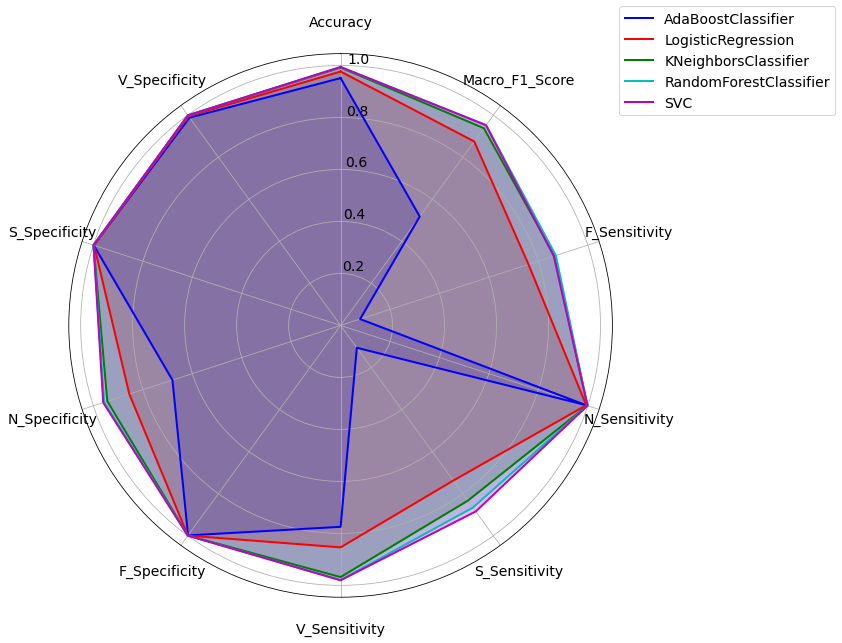

In [21]:
# 绘制雷达图
mpl.rcParams['font.size'] = 14  # 设置全局字体大小为14
categories = model_scores['SVC'].keys()

fig, ax = plt.subplots(figsize=(15, 10), subplot_kw=dict(polar=True))
colors = cycle(['b', 'r', 'g', 'c','m'])
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)

# 设置雷达图中的标签
ax.set_rlabel_position(np.pi / 2)
ax.set_xticks(np.linspace(0, 2 * np.pi, len(categories), endpoint=False))
ax.set_xticklabels(categories)
ax.tick_params(axis='x', pad=21)

# 将模型按性能从低到高排序
model_scores = dict(sorted(model_scores.items(), key=lambda x: sum(x[1].values())))

# 绘制每个模型的雷达图
for model_name, model_score in model_scores.items():
    color = next(colors)  # 获取下一个颜色
    values = list(model_score.values())
    values += values[:1]  # 闭合图形
    angles = [i / len(categories) * 2 * np.pi for i in range(len(categories))]
    angles += angles[:1]  # 闭合角度

    ax.plot(angles, values, linewidth=2, linestyle='solid', label=model_name, color=color)
    ax.fill(angles, values, alpha=0.25, color=color)

# 设置图例和标题
plt.legend(loc='upper left', bbox_to_anchor=(1, 1.1))
plt.savefig('figures/Model_Performance_Radar_Chart.jpg', dpi=300)
plt.show()

In [22]:
# 训练模型并评估测试集
model = SVC(C=10, kernel='rbf')
model_score = train_and_evaluate(model, final_feature_subset, train_y, test_feature_subset, test_y)
print("Model Score:", model_score)

Model Score: {'Accuracy': 0.930690279734353, 'Macro_F1_Score': 0.5368831857198102, 'Sensitivities': {'F': 0.002577319587628866, 'N': 0.9716352130184202, 'S': 0.26238432226456176, 'V': 0.8611801242236025}, 'Specificities': {'F': 0.9966994707078025, 'N': 0.6976119402985075, 'S': 0.9788042594700048, 'V': 0.9955026962508259}, 'Confusion_Matrix': array([[    1,   378,     0,     9],
       [  108, 42990,  1002,   145],
       [    2,  1296,   482,    57],
       [   54,   352,    41,  2773]], dtype=int64), 'TP': {'F': 1, 'N': 42990, 'S': 482, 'V': 2773}, 'TN': {'F': 49525, 'N': 4674, 'S': 48165, 'V': 46706}, 'FP': {'F': 164, 'N': 2026, 'S': 1043, 'V': 211}, 'FN': {'F': 387, 'N': 1255, 'S': 1355, 'V': 447}}


In [23]:
# 计算阳性似然比和阴性似然比
lrp = {}
lrn = {}
sen = model_score['Sensitivities']
spc = model_score['Specificities']
for c in sen:
    lrp[c] = sen[c] / (1 - spc[c])
    lrn[c] = (1 - sen[c]) / spc[c]

print('Positive Likelihood Ratio:', lrp)
print('Negative Likelihood Ratio:', lrn)

Positive Likelihood Ratio: {'F': 0.7808806889615248, 'N': 3.2132062819464045, 'S': 12.379106164903664, 'V': 191.48809425686417}
Negative Likelihood Ratio: {'F': 1.0007256045837518, 'N': 0.04065983585292789, 'S': 0.7535885450016703, 'V': 0.139447011343323}


In [24]:
# 查看特征F统计量排名
feature_f_statistic = zip(train_X_preprocessed.columns, f_statistic)
rank = sorted(feature_f_statistic, key=lambda x: x[1], reverse=True)
for i, r in enumerate(rank):
    print(f"{i+1}. {r[0]}: {r[1]:.2f}")

1. ps_kurt: 8949.77
2. ps_skew: 6427.75
3. kimfs_time_4_std: 4093.12
4. kimfs_freq_4_band_energy: 3746.98
5. kimfs_freq_4_total_energy: 3716.40
6. freq_exp: 3412.51
7. kimfs_freq_4_major_freq: 3183.32
8. freq_std: 3086.41
9. freq_peak: 2882.06
10. ps_std: 2860.32
11. kimfs_time_4_min_val: 2796.16
12. kimfs_time_4_max_val: 1975.62
13. std_freq_4: 1683.83
14. cA3_wavelet_14: 1510.08
15. cA3_wavelet_15: 1474.80
16. kimfs_time_2_max_val: 1372.69
17. ps_exp: 1336.87
18. cA3_wavelet_11: 1311.29
19. age: 1185.16
20. kimfs_time_2_min_val: 1154.14
21. kimfs_freq_2_major_freq: 1151.17
22. kimfs_time_2_std: 1134.32
23. cA3_wavelet_12: 1093.86
24. kimfs_time_4_zcr: 899.91
25. sv_3: 856.93
26. kimfs_time_3_max_val: 844.34
27. kimfs_freq_2_band_energy: 754.84
28. kimfs_freq_2_total_energy: 740.11
29. sv_5: 710.66
30. std_freq_7: 700.97
31. mean_freq_7: 639.34
32. mean_freq_6: 604.23
33. cA3_wavelet_10: 544.59
34. sex: 537.34
35. std_freq_6: 505.80
36. sv_4: 500.27
37. std_freq_8: 489.01
38. norm_pre

In [25]:
total_data = pd.concat([train_data, test_data], axis=0)
total_data.reset_index(drop=True, inplace=True)

# 绘制不同类型的特征对比图
time = ['pre_r', 'post_r', 'local_r', 'global_r', 'norm_pre_r', 'norm_post_r', 'norm_local_r','norm_global_r']
freq = ['ps_exp', 'ps_std', 'ps_skew', 'ps_kurt', 'freq_exp', 'freq_std', 'freq_peak', 'freq_bw']
timefreq = ['mean_freq_1', 'mean_freq_2', 'mean_freq_3', 'mean_freq_4',
       'mean_freq_5', 'mean_freq_6', 'mean_freq_7', 'mean_freq_8',
       'std_freq_1', 'std_freq_2', 'std_freq_3', 'std_freq_4', 'std_freq_5',
       'std_freq_6', 'std_freq_7', 'std_freq_8', 'cA3_wavelet_1',
       'cA3_wavelet_2', 'cA3_wavelet_3', 'cA3_wavelet_4', 'cA3_wavelet_5',
       'cA3_wavelet_6', 'cA3_wavelet_7', 'cA3_wavelet_8', 'cA3_wavelet_9',
       'cA3_wavelet_10', 'cA3_wavelet_11', 'cA3_wavelet_12', 'cA3_wavelet_13',
       'cA3_wavelet_14', 'cA3_wavelet_15', 'cA3_wavelet_16', 'cA3_wavelet_17',
       'cA3_wavelet_18', 'cA3_wavelet_19', 'cA3_wavelet_20', 'cA3_wavelet_21',
       'cA3_wavelet_22', 'cA3_wavelet_23', 'cA3_wavelet_24', 'cA3_wavelet_25']
decomposition = ['sv_1', 'sv_2', 'sv_3', 'sv_4', 'sv_5',
       'kimfs_time_1_mean', 'kimfs_time_1_std', 'kimfs_time_1_max_val',
       'kimfs_time_1_min_val', 'kimfs_time_1_zcr', 'kimfs_time_2_mean',
       'kimfs_time_2_std', 'kimfs_time_2_max_val', 'kimfs_time_2_min_val',
       'kimfs_time_2_zcr', 'kimfs_time_3_mean', 'kimfs_time_3_std',
       'kimfs_time_3_max_val', 'kimfs_time_3_min_val', 'kimfs_time_3_zcr',
       'kimfs_time_4_mean', 'kimfs_time_4_std', 'kimfs_time_4_max_val',
       'kimfs_time_4_min_val', 'kimfs_time_4_zcr', 'kimfs_freq_1_total_energy',
       'kimfs_freq_1_major_freq', 'kimfs_freq_1_band_energy',
       'kimfs_freq_2_total_energy', 'kimfs_freq_2_major_freq',
       'kimfs_freq_2_band_energy', 'kimfs_freq_3_total_energy',
       'kimfs_freq_3_major_freq', 'kimfs_freq_3_band_energy',
       'kimfs_freq_4_total_energy', 'kimfs_freq_4_major_freq',
       'kimfs_freq_4_band_energy']
nonlinear = ['apen', 'sampen', 'fuzzyen']

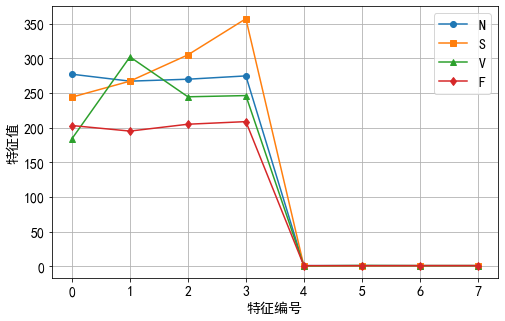

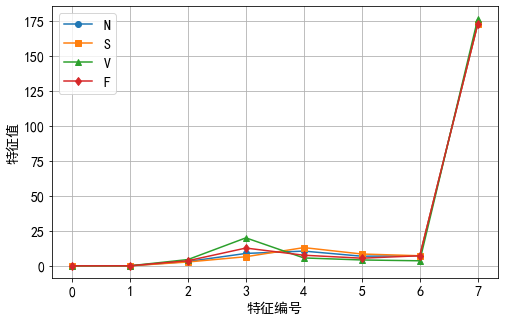

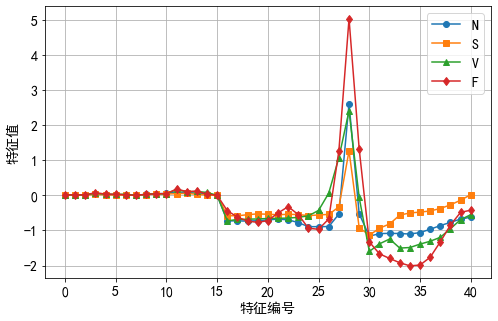

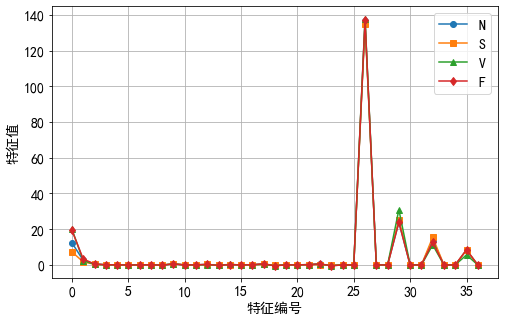

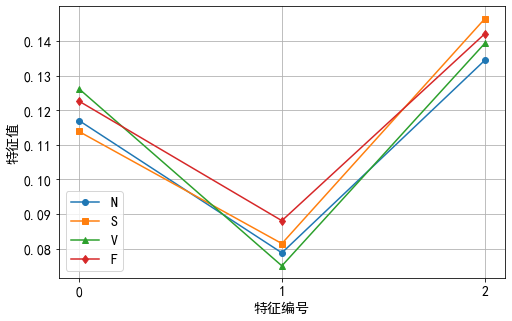

In [26]:
cols = [time, freq, timefreq, decomposition, nonlinear]
N = total_data[total_data['symbol'] == 'N']
S = total_data[total_data['symbol'] == 'S']
V = total_data[total_data['symbol'] == 'V']
F = total_data[total_data['symbol'] == 'F']

mpl.rcParams['font.size'] = 14  # 设置全局字体大小为14
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号


filename = ['time', 'freq', 'timefreq', 'decomposition', 'nonlinear']

for i, col in enumerate(cols):
    # 计算各个特征的中位数
    N_feature = N[col].median()
    S_feature = S[col].median()
    V_feature = V[col].median()
    F_feature = F[col].median()

    # 绘制特征分布图
    
    plt.figure(figsize=(8, 5))  # 设置图表大小
    n = len(col)
    x = range(n)
    plt.plot(x, N_feature, label='N', marker='o')  # 标记为圆形
    plt.plot(x, S_feature, label='S', marker='s')  # 标记为正方形
    plt.plot(x, V_feature, label='V', marker='^')  # 标记为三角形
    plt.plot(x, F_feature, label='F', marker='d')  # 标记为菱形

    # 添加标题和标签
    plt.xlabel('特征编号')
    plt.ylabel('特征值')
    if n == 3:
        plt.xticks(x)  # 设置x轴标签
    plt.legend()  # 显示图例

    # 显示网格
    plt.grid(True)

    # 保存图表
    plt.savefig(f'figures/{filename[i]}_distribution.jpg', dpi=300)

    # 显示图表
    plt.show()

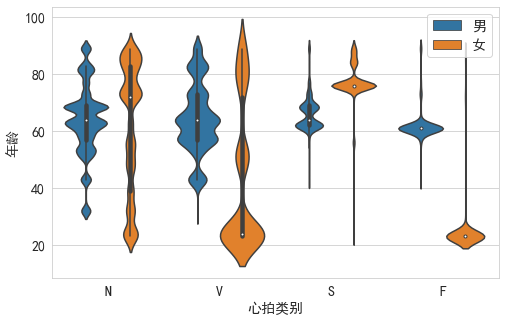

In [27]:
# 绘制性别和年龄分布图
import seaborn as sns

# 设置绘图风格
sns.set_style('whitegrid')

plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False  # 用来正常显示负号

# 设置图片大小
plt.figure(figsize=(8, 5))

# 绘制年龄分布图
sns.violinplot(x="symbol", y="age",hue="sex", data=total_data)
plt.xlabel('心拍类别')
plt.ylabel('年龄')

# 修改图例名称
current_legend = plt.legend()
current_legend.texts[0].set_text('男')
current_legend.texts[1].set_text('女')

plt.savefig('figures/sex_age_distribution.jpg', dpi=300)
plt.show()